In [4]:
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import spacy
import seaborn as sns


# Import local functions
from general_functions import *

# Import functions
from collections import Counter
from spacy import displacy

In [5]:
# Import data
# Access aws credentials from json file
with open("aws_credentials.json", 'r') as file:
    aws_creds_json = json.load(file)
# Specify s3 bucket
bucket = "fs-reghub-news-analysis"

# Connect to aws and dowload the files
aws = awsOps(aws_creds_json)
df = aws.get_df(bucket=bucket, file="data_rule_labels_v1.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14501 entries, 0 to 14500
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         14501 non-null  int64  
 1   _id                14501 non-null  object 
 2   _index             14501 non-null  object 
 3   _score             11 non-null     object 
 4   _type              14491 non-null  object 
 5   concepts           2254 non-null   object 
 6   found_dates        13779 non-null  object 
 7   id                 14501 non-null  object 
 8   internal_links     13731 non-null  object 
 9   keywords           2360 non-null   object 
 10  language           14492 non-null  object 
 11  news_author        1979 non-null   object 
 12  news_content       14501 non-null  object 
 13  news_date          14490 non-null  object 
 14  news_label         238 non-null    object 
 15  news_last_updated  11 non-null     object 
 16  news_legalinforce  144

In [7]:
df

,Unnamed: 0,_id,_index,_score,_type,concepts,found_dates,id,internal_links,keywords,...,news_title,news_topic,news_type,references,sentiment_label,sentiment_score,source_country,source_name,source_type,rule_labels_comb
0,0,fin1023Preslofreshbuy917302,2021_reghub_new,NaN,_doc,NaN,[],fin1023Preslofreshbuy917302,[],NaN,...,HelloFresh Buy von Joh. Berenberg Gossler & Co...,"[{""description"":""Berenberg Bank"",""relevance"":4...",Press releases,[],NaN,0.0,Global,finanzen.at,Information Provider,['market']
1,1,finichtenStoceaaufbuy322htm,2021_reghub_new,NaN,_doc,NaN,[],finichtenStoceaaufbuy322htm,[],NaN,...,BERENBERG stuft Nordea auf 'Buy' Finanznachri...,"[{""description"":""Berenberg Bank"",""relevance"":6...",Stock Analysis,[],NaN,0.0,Global,finanznachrichten.de,Information Provider,['market']
2,2,fin1023Pressanofibuy917301,2021_reghub_new,NaN,_doc,NaN,[],fin1023Pressanofibuy917301,[],NaN,...,Sanofi Buy von Joh. Berenberg Gossler & Co. KG...,"[{""description"":""Berenberg Bank"",""relevance"":4...",Press releases,[],NaN,0.0,Global,finanzen.ch,Information Provider,['market']
3,3,fin02023Presnbergbank917304,2021_reghub_new,NaN,_doc,NaN,[],fin02023Presnbergbank917304,[],NaN,...,Sartorius vz Buy (Joh. Berenberg Gossler & Co....,"[{""description"":""Berenberg Bank"",""relevance"":4...",Press releases,[],NaN,0.0,Global,finanzen.net,Information Provider,[]
4,4,walOnlineStocgstuftsanofibuy,2021_reghub_new,NaN,_doc,NaN,[],walOnlineStocgstuftsanofibuy,[],NaN,...,BERENBERG stuft SANOFI auf 'Buy' 30.10.2023 ...,"[{""description"":""Berenberg Bank"",""relevance"":6...",Stock Analysis,[],NaN,0.0,Global,wallstreet-online.de,Information Provider,"['papers', 'market']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496,14603,EurchosPres9fa0e44b60enhtml,2021_reghub_new,NaN,_doc,NaN,[],EurchosPres9fa0e44b60enhtml,[],NaN,...,Andrea Enria: Interview with Les Échos,"[{""description"":""Compliance"",""relevance"":7,""co...",Press releases,[],NaN,0.0,European Union (EU),European Central Bank (ECB),Central bank,"['legal', 'statements', 'guidelines']"
14497,14604,UBSWillPresllhtmlcaasIDRSS,2021_reghub_new,NaN,_doc,NaN,[],UBSWillPresllhtmlcaasIDRSS,[],NaN,...,Das FintechPortfolio von UBS investiert in die...,"[{""description"":""Digital Transformation"",""rele...",Press releases,[],NaN,0.0,Global,UBS Media Releases,Financial Service Provider,"['reports', 'personnel']"
14498,14605,invrankenPresnd26mrdfranken,2021_reghub_new,NaN,_doc,NaN,[],invrankenPresnd26mrdfranken,[],NaN,...,SNB erwartet für 2021 Jahresgewinn von rund 26...,"[{""description"":""Controlling"",""relevance"":33,""...",Press releases,[],NaN,0.0,Switzerland,investrends,Information provider,"['legal', 'reports', 'market']"
14499,14606,CoirawalsPrestomerswithdrawals,2021_reghub_new,NaN,_doc,NaN,[],CoirawalsPrestomerswithdrawals,[],NaN,...,Hong Kongbased Coinsuper allegedly blocks cust...,"[{""description"":""Daytrading"",""relevance"":49,""c...",Social Media,[],NaN,0.0,Global,Cointelegraph,Information provider,"['legal', 'reports', 'guidelines', 'press']"


In [26]:
%%capture
!python -m spacy download en_core_web_lg

In [27]:
nlp_en = spacy.load("en_core_web_lg")

## Demo

In [28]:
doc=nlp_en('India and Iran have agreed to boost the economic viability of the strategic Chabahar port through various measures, including larger subsidies to merchant shipping firms using the facility, people familiar with the development said on Thursday.')

[(x.text,x.label_) for x in doc.ents]

[('India', 'GPE'), ('Iran', 'GPE'), ('Chabahar', 'GPE'), ('Thursday', 'DATE')]

In [29]:
displacy.render(doc, style='ent')

## Model - English - News Title

In [34]:
# Load the German language model
nlp_en = spacy.load('en_core_web_lg')

# Access the pipeline components to get the labels
ner_labels = nlp_en.get_pipe("ner").labels

# Print the labels and their descriptions
for label in ner_labels:
    print(f"Type: {label}, Description: {spacy.explain(label)}")

Type: CARDINAL, Description: Numerals that do not fall under another type
Type: DATE, Description: Absolute or relative dates or periods
Type: EVENT, Description: Named hurricanes, battles, wars, sports events, etc.
Type: FAC, Description: Buildings, airports, highways, bridges, etc.
Type: GPE, Description: Countries, cities, states
Type: LANGUAGE, Description: Any named language
Type: LAW, Description: Named documents made into laws.
Type: LOC, Description: Non-GPE locations, mountain ranges, bodies of water
Type: MONEY, Description: Monetary values, including unit
Type: NORP, Description: Nationalities or religious or political groups
Type: ORDINAL, Description: "first", "second", etc.
Type: ORG, Description: Companies, agencies, institutions, etc.
Type: PERCENT, Description: Percentage, including "%"
Type: PERSON, Description: People, including fictional
Type: PRODUCT, Description: Objects, vehicles, foods, etc. (not services)
Type: QUANTITY, Description: Measurements, as of weight 

In [35]:
# Filter DataFrame for English and German content
df_en = df[df['language'] == 'en']
df_de = df[df['language'] == 'de']

<Axes: >

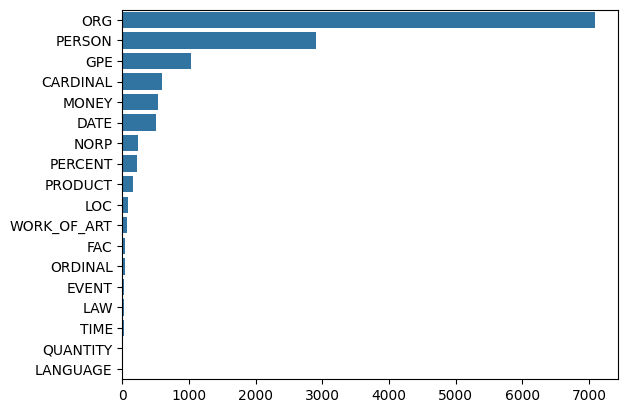

In [55]:
# Define the NER function
def ner_en_tit(text, ent=None):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_en(text)
        return [X.label_ for X in doc.ents]
    else:
        return []

# Apply the NER function to the 'news_title' column, handling float values
ent_en = df_en['news_title'].apply(lambda x: ner_en_tit(x))
ent_en = [i for x in ent_en for i in x]

# Count the occurrences of each entity
counter = Counter(ent_en)
count = counter.most_common()

x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

<Axes: >

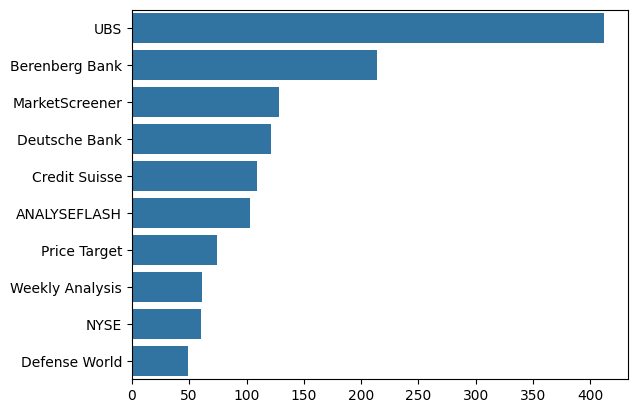

In [56]:
def ner_en_tit(text, ent="ORG"):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_en(text)
        return [X.text for X in doc.ents if X.label_ == ent]
    else:
        return []


# Apply the NER function to the 'headline_text' column, handling float values
org_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, ent="ORG"))
org_en = [i for x in org_en for i in x]

# Count the occurrences of each entity
counter = Counter(org_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

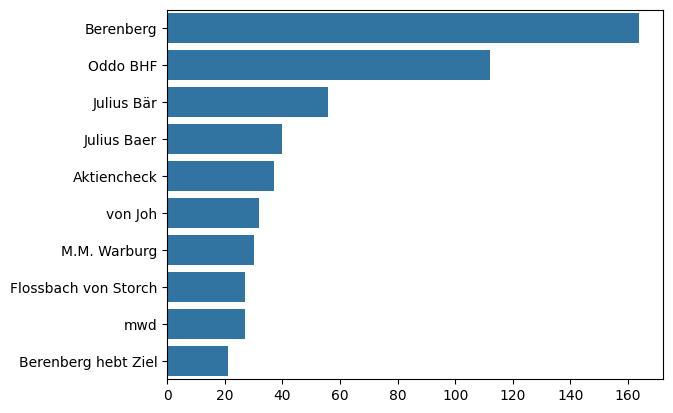

In [57]:
# Apply the NER function to the 'headline_text' column, handling float values
per_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, ent="PERSON"))
per_en = [i for x in per_en for i in x]

# Count the occurrences of each entity
counter = Counter(per_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

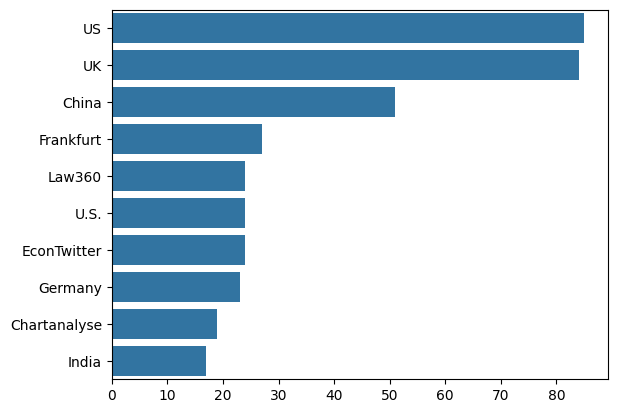

In [58]:
# Apply the NER function to the 'headline_text' column, handling float values
gpe_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, "GPE"))
gpe_en = [i for x in gpe_en for i in x]

# Count the occurrences of each entity
counter = Counter(gpe_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

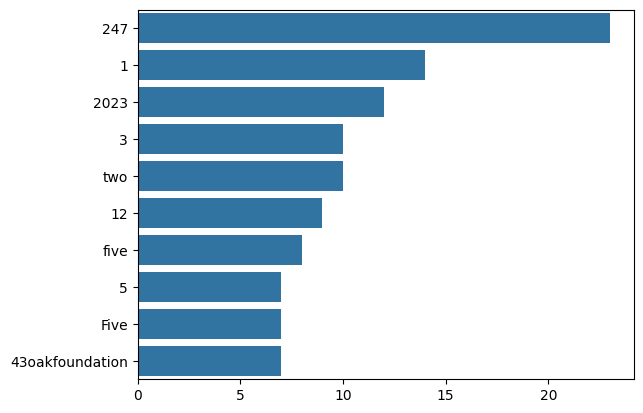

In [59]:
# Apply the NER function to the 'headline_text' column, handling float values
car_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, "CARDINAL"))
car_en = [i for x in car_en for i in x]

# Count the occurrences of each entity
counter = Counter(car_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

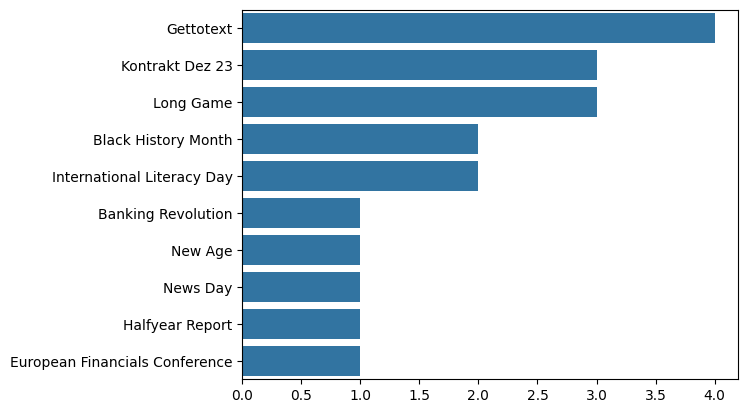

In [60]:
# Apply the NER function to the 'headline_text' column, handling float values
eve_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, "EVENT"))
eve_en = [i for x in eve_en for i in x]

# Count the occurrences of each entity
counter = Counter(eve_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

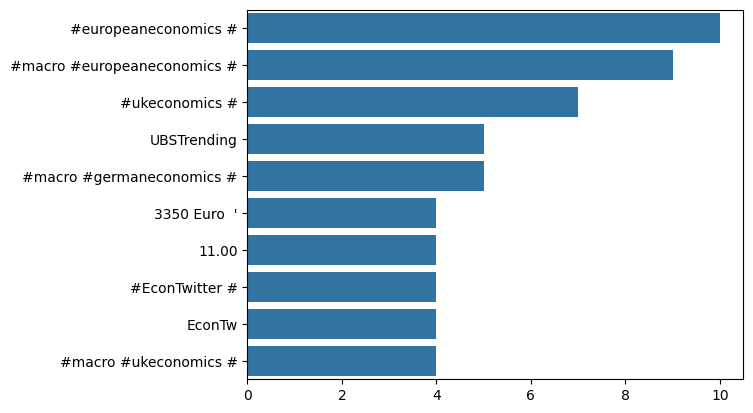

In [61]:
# Apply the NER function to the 'headline_text' column, handling float values
mon_en = df_en['news_title'].apply(lambda x: ner_en_tit(x, "MONEY"))
mon_en = [i for x in mon_en for i in x]

# Count the occurrences of each entity
counter = Counter(mon_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

## Model - German - News Title

In [62]:
%%capture
!python -m spacy download de_core_news_lg

In [63]:
# Load the German language model
nlp_de = spacy.load('de_core_news_lg')

# Access the pipeline components to get the labels
ner_labels = nlp_de.get_pipe("ner").labels

# Print the labels and their descriptions
for label in ner_labels:
    print(f"Type: {label}, Description: {spacy.explain(label)}")

Type: LOC, Description: Non-GPE locations, mountain ranges, bodies of water
Type: MISC, Description: Miscellaneous entities, e.g. events, nationalities, products or works of art
Type: ORG, Description: Companies, agencies, institutions, etc.
Type: PER, Description: Named person or family.


<Axes: >

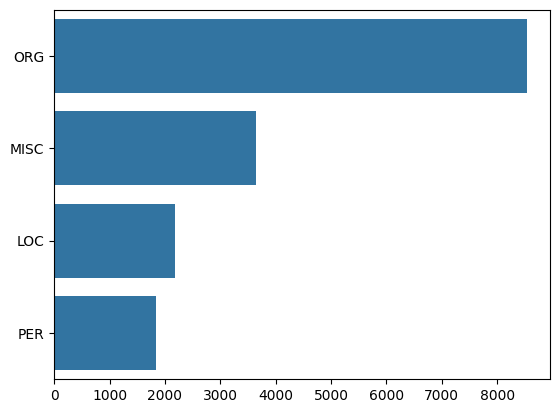

In [64]:
# Define the NER function
def ner_de_tit(text, ent=None):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_de(text)
        return [X.label_ for X in doc.ents]
    else:
        return []

# Apply the NER function to the 'news_title' column, handling float values
ent_de = df_de['news_title'].apply(lambda x: ner_de_tit(x))
ent_de = [i for x in ent_de for i in x]

# Count the occurrences of each entity
counter = Counter(ent_de)
count = counter.most_common()

x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

<Axes: >

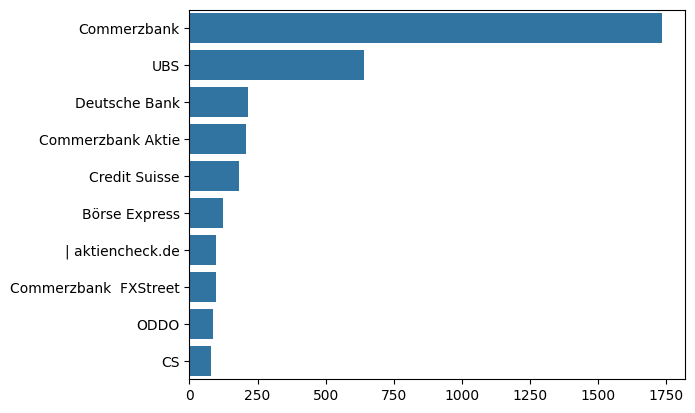

In [65]:
def ner_de_tit(text, ent="ORG"):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_de(text)
        return [X.text for X in doc.ents if X.label_ == ent]
    else:
        return []


# Apply the NER function to the 'headline_text' column, handling float values
org_de = df_de['news_title'].apply(lambda x: ner_de_tit(x, ent="ORG"))
org_de = [i for x in org_de for i in x]

# Count the occurrences of each entity
counter = Counter(org_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

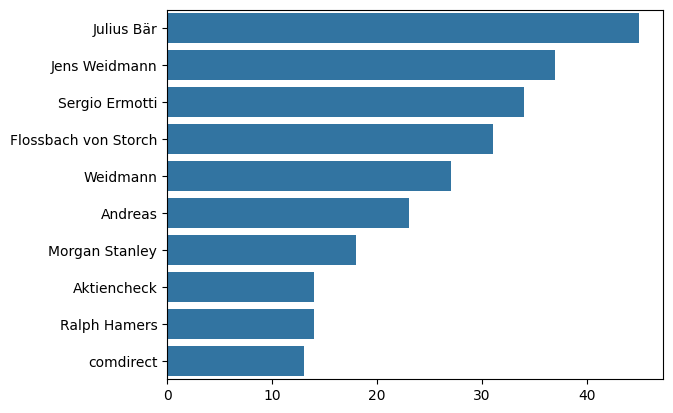

In [66]:
# Apply the NER function to the 'headline_text' column, handling float values
per_de = df_de['news_title'].apply(lambda x: ner_de_tit(x, "PER"))
per_de = [i for x in per_de for i in x]

# Count the occurrences of each entity
counter = Counter(per_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

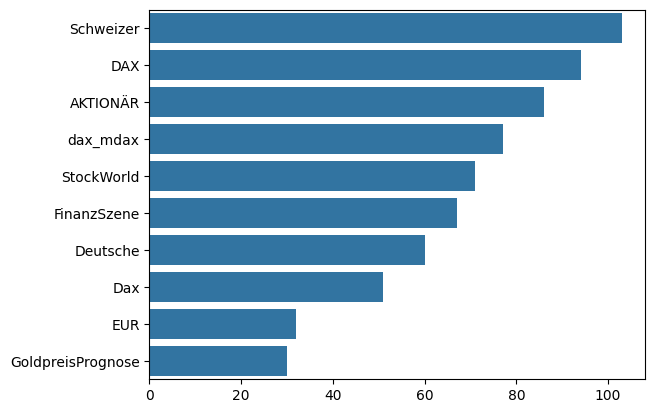

In [67]:
# Apply the NER function to the 'headline_text' column, handling float values
misc_de = df_de['news_title'].apply(lambda x: ner_de_tit(x, "MISC"))
misc_de = [i for x in misc_de for i in x]

# Count the occurrences of each entity
counter = Counter(misc_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

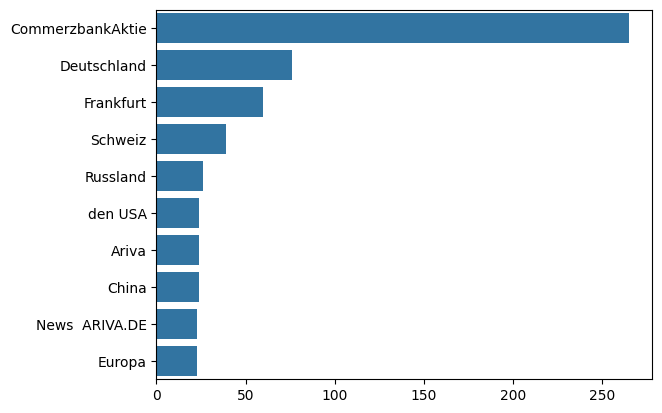

In [68]:
# Apply the NER function to the 'headline_text' column, handling float values
loc_de = df_de['news_title'].apply(lambda x: ner_de_tit(x, "LOC"))
loc_de = [i for x in loc_de for i in x]

# Count the occurrences of each entity
counter = Counter(loc_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

## Model - English - News Content

<Axes: >

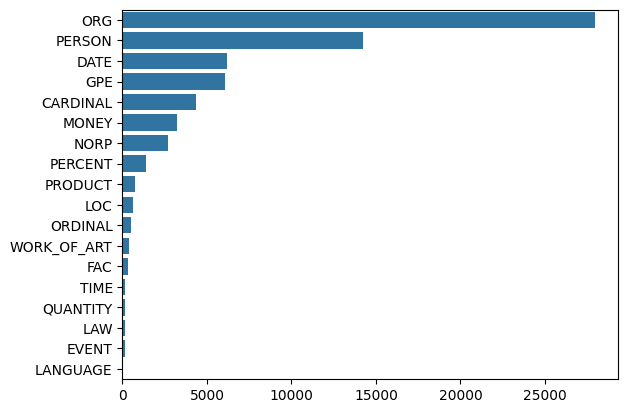

In [69]:
# Define the NER function
def ner_en_cont(text):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_en(text)
        return [X.label_ for X in doc.ents]
    else:
        return []

# Apply the NER function to the 'news_title' column, handling float values
ent_en = df_en['news_content'].apply(lambda x: ner_en_cont(x))
ent_en = [i for x in ent_en for i in x]

# Count the occurrences of each entity
counter = Counter(ent_en)
count = counter.most_common()

x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

<Axes: >

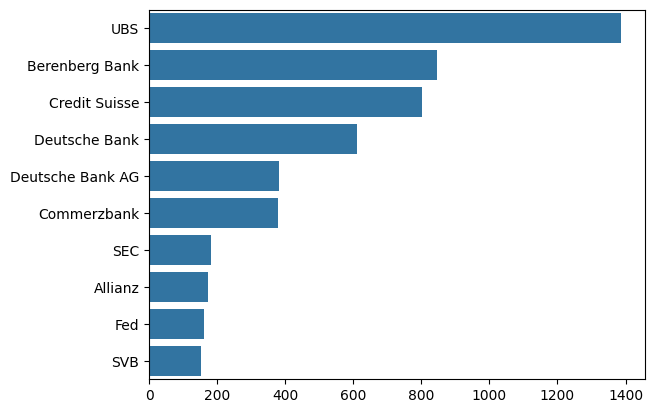

In [70]:
def ner_en_cont(text, ent="ORG"):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_en(text)
        return [X.text for X in doc.ents if X.label_ == ent]
    else:
        return []


# Apply the NER function to the 'headline_text' column, handling float values
org_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, ent="ORG"))
org_en = [i for x in org_en for i in x]

# Count the occurrences of each entity
counter = Counter(org_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

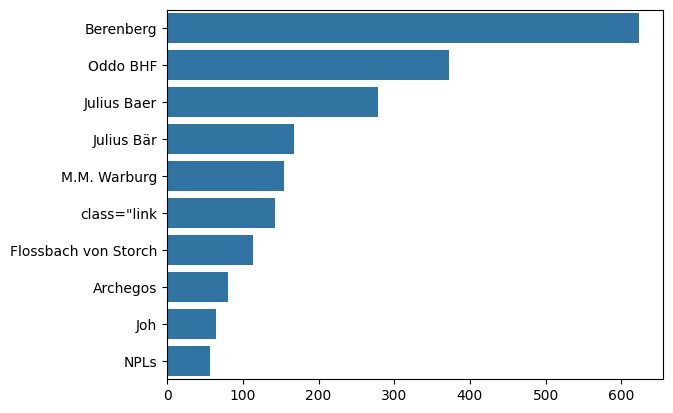

In [71]:
# Apply the NER function to the 'headline_text' column, handling float values
per_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, "PERSON"))
per_en = [i for x in per_en for i in x]

# Count the occurrences of each entity
counter = Counter(per_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

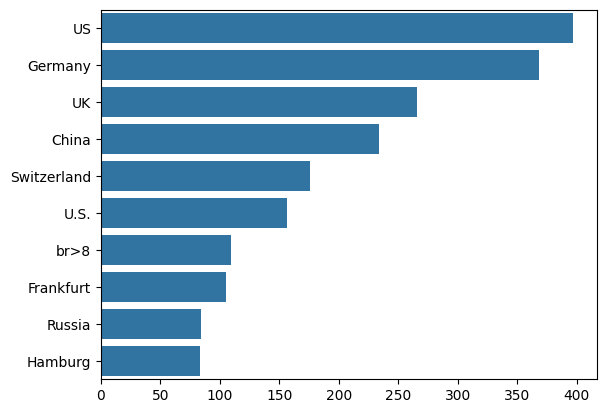

In [72]:
# Apply the NER function to the 'headline_text' column, handling float values
gpe_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, "GPE"))
gpe_en = [i for x in gpe_en for i in x]

# Count the occurrences of each entity
counter = Counter(gpe_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

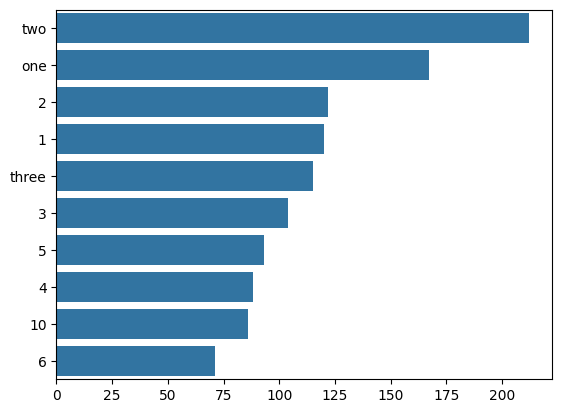

In [73]:
# Apply the NER function to the 'headline_text' column, handling float values
car_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, "CARDINAL"))
car_en = [i for x in car_en for i in x]

# Count the occurrences of each entity
counter = Counter(car_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

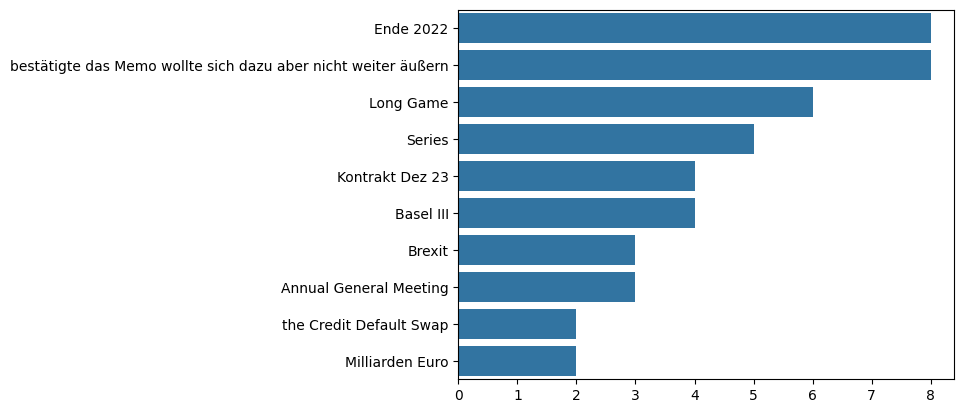

In [74]:
# Apply the NER function to the 'headline_text' column, handling float values
eve_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, "EVENT"))
eve_en = [i for x in eve_en for i in x]

# Count the occurrences of each entity
counter = Counter(eve_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

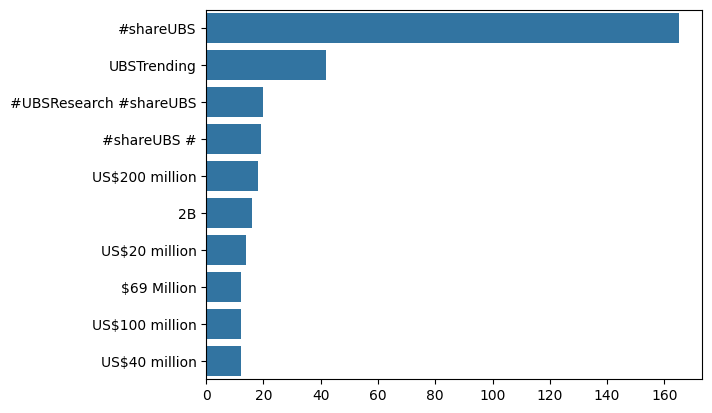

In [75]:
# Apply the NER function to the 'headline_text' column, handling float values
mon_en = df_en['news_content'].apply(lambda x: ner_en_cont(x, "MONEY"))
mon_en = [i for x in mon_en for i in x]

# Count the occurrences of each entity
counter = Counter(mon_en)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

## Model - German - News Content

<Axes: >

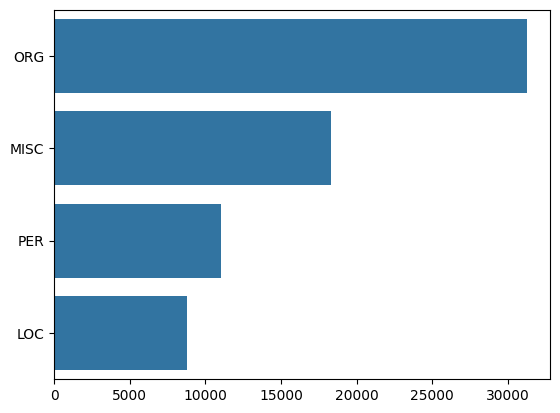

In [76]:
# Define the NER function
def ner_de_cont(text):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_de(text)
        return [X.label_ for X in doc.ents]
    else:
        return []

# Apply the NER function to the 'news_title' column, handling float values
ent_de = df_de['news_content'].apply(lambda x: ner_de_cont(x))
ent_de = [i for x in ent_de for i in x]

# Count the occurrences of each entity
counter = Counter(ent_de)
count = counter.most_common()

x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

<Axes: >

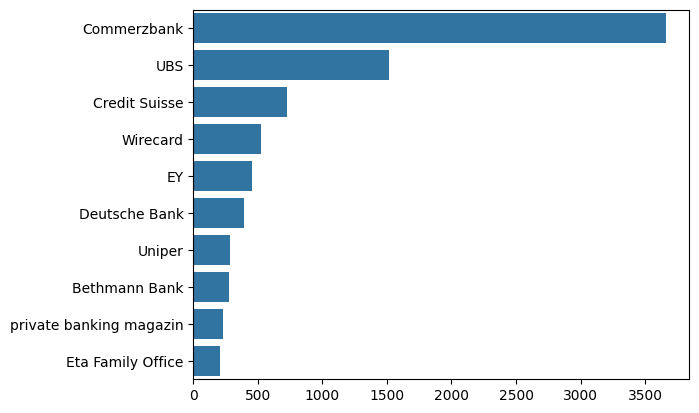

In [82]:
def ner_de_cont(text, ent="ORG"):
    if isinstance(text, str):  # Check if the value is a string
        doc = nlp_de(text)
        return [X.text for X in doc.ents if X.label_ == ent]
    else:
        return []


# Apply the NER function to the 'headline_text' column, handling float values
org_de = df_de['news_content'].apply(lambda x: ner_de_cont(x, ent="ORG"))
org_de = [i for x in org_de for i in x]

# Count the occurrences of each entity
counter = Counter(org_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

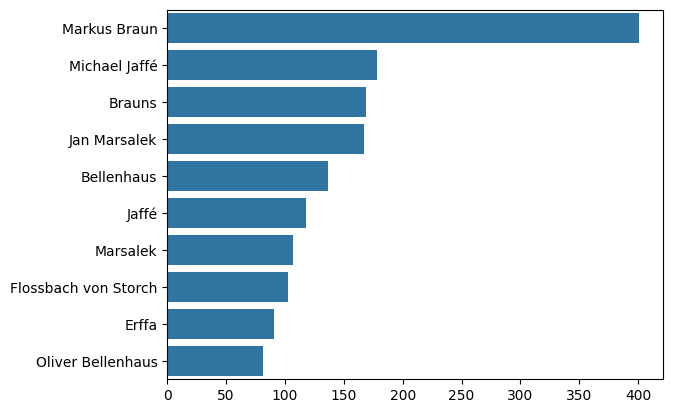

In [83]:
# Apply the NER function to the 'headline_text' column, handling float values
per_de = df_de['news_content'].apply(lambda x: ner_de_cont(x, "PER"))
per_de = [i for x in per_de for i in x]

# Count the occurrences of each entity
counter = Counter(per_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

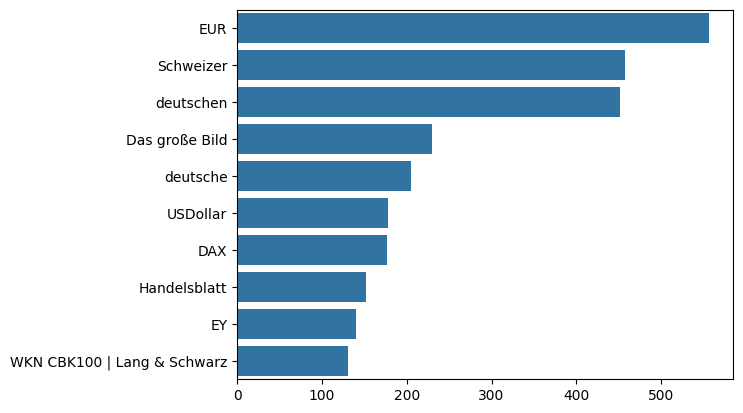

In [84]:
# Apply the NER function to the 'headline_text' column, handling float values
misc_de = df_de['news_content'].apply(lambda x: ner_de_cont(x, "MISC"))
misc_de = [i for x in misc_de for i in x]

# Count the occurrences of each entity
counter = Counter(misc_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)

<Axes: >

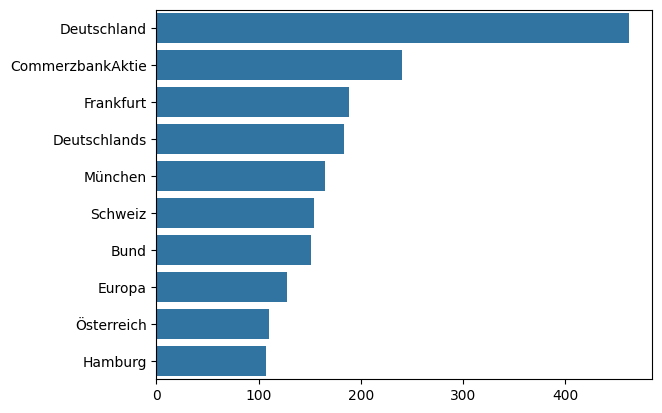

In [85]:
# Apply the NER function to the 'headline_text' column, handling float values
loc_de = df_de['news_content'].apply(lambda x: ner_de_cont(x, "LOC"))
loc_de = [i for x in loc_de for i in x]

# Count the occurrences of each entity
counter = Counter(loc_de)

# Extract the top 10 entities and their counts
x, y = map(list, zip(*counter.most_common(10)))

# Create a bar plot
sns.barplot(x=y, y=x)